In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/Nature-Full/merry_mexico0060.tif
/kaggle/input/Nature-Full/pippin_UniStrt025.tif
/kaggle/input/Nature-Full/pippin_Peel059.tif
/kaggle/input/Nature-Full/merry0060.tif
/kaggle/input/Nature-Full/pippin_wei090.tif
/kaggle/input/Nature-Full/pippin_wei061.tif
/kaggle/input/Nature-Full/pippin_wei117.tif
/kaggle/input/Nature-Full/merry0192.tif
/kaggle/input/Nature-Full/pippin_adirondacks0002.tif
/kaggle/input/Nature-Full/merry_mexico0063.tif
/kaggle/input/Nature-Full/pippin_park0056.tif
/kaggle/input/Nature-Full/pippin0199.tif
/kaggle/input/Nature-Full/Merry_0010_Lasalle.tif
/kaggle/input/Nature-Full/Merry_0038_Lasalle.tif
/kaggle/input/Nature-Full/pippin_Peel040.tif
/kaggle/input/Nature-Full/merry_mexico0201.tif
/kaggle/input/Nature-Full/pippin_jtalon0027.tif
/kaggle/input/Nature-Full/MERRY0013.tif
/kaggle/input/Nature-Full/pippin0285.tif
/kaggle/input/Nature-Full/pippin_wei129.tif
/kaggle/input/Nature-Full/merry_mtl07_049.tif
/kaggle/input/Nature-Full/merry_flor0013.tif
/kaggle

In [2]:
import os
import numpy as np
import random
import pandas as pd
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.1.0-rc0


In [3]:
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb, deltaE_ciede2000, deltaE_cie76
import albumentations as A
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, RepeatVector, concatenate, UpSampling2D
from tensorflow.keras.layers import Activation, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model, Sequence

In [4]:
BATCH_SIZE = 64
TARGET_SIZE = (224,224)

# Data Processing Functions

In [5]:
def getImageArray(FOLDER_PATH, target_size=TARGET_SIZE, isColor=True, isSplit=True, test_split=0.1):
    img_files_lst = os.listdir(FOLDER_PATH)
    img_files_lst.sort()
    num_images = len(img_files_lst)
    x = []
    if isColor == True:
        color_mode = 'rgb'
    else:
        color_mode = 'grayscale'
    for img in img_files_lst:
        img_arr = img_to_array(load_img(path=FOLDER_PATH + '/' + img, target_size=target_size, color_mode=color_mode)) * 1.0/255
        x.append(img_arr)
    x = np.array(x)
    print('Finished converting', str(num_images), 'images as numpy arrays!')
    print('Image pixels are in range', x.min(), 'to', x.max())
    if isSplit == True:
        train, test = train_test_split(x, test_size=test_split)
        print('Train Shape:', train.shape)
        print('Test  Shape:', test.shape)
        return train, test
    return x

In [6]:
def getLabBatch(batch):
    lab_batch = rgb2lab(batch)
    X_batch = lab_batch[:,:,:,0]
    Y_batch = lab_batch[:,:,:,1:] / 128
    return (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

In [7]:
def getColorBatch(batch):
    X_batch = rgb2gray(batch)
    Y_batch = batch
    return (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

In [8]:
def getTrainValBatch(generator, isLab):
    for batch in generator:
        if isLab == True:
            yield getLabBatch(batch)
        else:
            yield getColorBatch(batch)

In [9]:
def concatLandAB(color_me,output):
    result_list=[]
    for i in range(len(output)):
        result = np.zeros((224, 224, 3))
        result[:,:,0] = color_me[i][:,:,0]
        result[:,:,1:] = output[i]
        #imsave("result"+i+".png", lab2rgb(result))
        result_list.append(result)
    return result_list

In [10]:
folder_path = '/kaggle/input/Nature-Full'
train, test= getImageArray(folder_path, TARGET_SIZE, isColor=True)

Finished converting 258 images as numpy arrays!
Image pixels are in range 0.0 to 1.0
Train Shape: (232, 224, 224, 3)
Test  Shape: (26, 224, 224, 3)


In [11]:
def getProcessedData(arr):
    arr_lab = rgb2lab(arr)
    X = 2 *arr_lab
    X = np.expand_dims(X, axis=3)
    Y = arr_lab[:, :, :, 1:] / 128 # scale to [-1, 1]
    print('Shape of X:', X.shape, 'with pixels in range', X.min(), 'to', X.max())
    print('Shape of Y:', Y.shape, 'with pixels in range', Y.min(), 'to', Y.max())
    return X, Y

# Data Generator

In [12]:
VAL_SPLIT = 0.131
BATCH_SIZE = 32

In [13]:
imageGenerator = ImageDataGenerator(data_format='channels_last', validation_split=VAL_SPLIT, 
                                    shear_range=0.2, zoom_range=0.2, rotation_range=40,
                                    width_shift_range=0.2, height_shift_range=0.2, 
                                    horizontal_flip=True, vertical_flip=True)

print('\t\t\tTrain and Val Generator')
train_gen = imageGenerator.flow_from_directory(directory='/kaggle/input', subset='training', classes=['Nature-Full'], 
                                               class_mode=None, target_size=TARGET_SIZE, batch_size=BATCH_SIZE)
val_gen = imageGenerator.flow_from_directory(directory='/kaggle/input', subset='validation', classes=['Nature-Full'], 
                                             class_mode=None, target_size=TARGET_SIZE, batch_size=BATCH_SIZE)

			Train and Val Generator
Found 225 images belonging to 1 classes.
Found 33 images belonging to 1 classes.


In [14]:
# check size/scale for train and val images
x = train_gen[0]
print('Shape of TRAIN Batch:', x[0].shape, 'with images in range', x[0].min(), 'to', x[0].max())
x = val_gen[0]
print('Shape of VAL Batch:', x[0].shape, 'with images in range', x[0].min(), 'to', x[0].max())

Shape of TRAIN Batch: (224, 224, 3) with images in range 0.0 to 255.0
Shape of VAL Batch: (224, 224, 3) with images in range 0.0 to 254.38828


In [15]:
type(test)

numpy.ndarray

In [16]:
# load test data as numpy
test_gray = rgb2gray(test)
test_gray = test_gray.reshape(test_gray.shape+(1,))
print('Shape of TEST COLOR:', test.shape, 'with images in range', test.min(), 'to', test.max())
print('Shape of TEST GRAY:', test_gray.shape, 'with images in range', test_gray.min(), 'to', test_gray.max())

Shape of TEST COLOR: (26, 224, 224, 3) with images in range 0.0 to 1.0
Shape of TEST GRAY: (26, 224, 224, 1) with images in range 0.0 to 0.99999994


In [28]:
train_lab = rgb2lab(train)
train_X = train_lab[:, :, :, 0] / 100
train_X = train_X.reshape(train_X.shape+(1,))
train_Y = train_lab[:, :, :, 1:] / 128

print('\nShape of TRAIN:      ', train.shape, 'with pixels in range', train.min(), 'to', train.max())
print('Shape of TRAIN LAB:  ', train_lab.shape, 'with pixels in range', train_lab.min(), 'to', train_lab.max())
print('Shape of TRAIN X:    ', train_X.shape, 'with pixels in range', train_X.min(), 'to', train_X.max())
print('Shape of TRAIN Y:    ', train_Y.shape, 'with pixels in range', train_Y.min(), 'to', train_Y.max())


Shape of TRAIN:       (232, 224, 224, 3) with pixels in range 0.0 to 1.0
Shape of TRAIN LAB:   (232, 224, 224, 3) with pixels in range -73.87748829520977 to 100.0
Shape of TRAIN X:     (232, 224, 224, 1) with pixels in range 0.0 to 1.0
Shape of TRAIN Y:     (232, 224, 224, 2) with pixels in range -0.5771678773063263 to 0.718763562998213


In [29]:
test_lab = rgb2lab(test)
test_X = test_lab[:, :, :, 0] / 100
test_X = test_X.reshape(test_X.shape+(1,))
test_Y = test_lab[:, :, :, 1:] / 128

print('\nShape of TEST:      ', test.shape, 'with pixels in range', test.min(), 'to', test.max())
print('Shape of TEST LAB:  ', test_lab.shape, 'with pixels in range', test_lab.min(), 'to', test_lab.max())
print('Shape of TEST X:    ', test_X.shape, 'with pixels in range', test_X.min(), 'to', test_X.max())
print('Shape of TEST Y:    ', test_Y.shape, 'with pixels in range', test_Y.min(), 'to', test_Y.max())


Shape of TEST:       (26, 224, 224, 3) with pixels in range 0.0 to 1.0
Shape of TEST LAB:   (26, 224, 224, 3) with pixels in range -66.06840335448581 to 100.0
Shape of TEST X:     (26, 224, 224, 1) with pixels in range 0.0 to 1.0
Shape of TEST Y:     (26, 224, 224, 2) with pixels in range -0.5161594012069204 to 0.7059307241307445


# Model

In [30]:
def conv_block(x, num_filters, kernel_size, num_strides, activation, kernel_initializer, addBN, addDR, dRate, name):
    x = Conv2D(filters=num_filters, kernel_size=kernel_size, strides=num_strides, kernel_initializer=kernel_initializer,
               padding='same', name=name)(x)
    if addBN == True:
        x = BatchNormalization(name='bn_' + name)(x)
    if addDR == True:
        x = Dropout(dRate, name='dr_' + name)(x)
    x = Activation(activation, name='act_' + name)(x)
    return x

In [31]:
def convT_block(x, num_filters, kernel_size, num_strides, activation, kernel_initializer, kernel_regularizer, addBN, addDR, dRate, name):
    x = Conv2DTranspose(filters=num_filters, kernel_size=kernel_size, strides=num_strides,
                        kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer,
                        padding='same', name=name)(x)
    if addBN == True:
        x = BatchNormalization(name='bn_' + name)(x)
    if addDR == True:
        x = Dropout(dRate, name='dr_' + name)(x)
    x = Activation(activation, name='act_' + name)(x)
    return x

In [32]:

def CNN(input_shape, num_filters, kernel_size, num_strides, num_layers, activation, kernel_initializer,
        kernel_regularizer, addBN, optimizer, loss, model_name):
    in_layer = Input(shape=input_shape)
    x = in_layer
    # multiply starting filters with [1, 2, 4, 8, 16] if num_layers = 4
    for i in [2 ** j for j in range(num_layers)]:
        x = Conv2D(filters=num_filters * i, kernel_size=kernel_size, kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer, padding='same', strides=num_strides,
                   name='conv_' + str(num_filters * i))(x)
        x = Activation(activation, name='conv_act_' + str(num_filters * i))(x)
        if addBN == True:
            x = BatchNormalization(name='conv_BN_' + str(num_filters * i))(x)
        x = Conv2D(filters=num_filters * i, kernel_size=kernel_size, kernel_initializer=kernel_initializer,
                   kernel_regularizer=kernel_regularizer, padding='same', strides=2,
                   name='stridePool_' + str(num_filters * i))(x)
        x = Activation(activation, name='stridePool_act_' + str(num_filters * i))(x)
        if addBN == True:
            x = BatchNormalization(name='stridePool_BN_' + str(num_filters * i))(x)

    # multiply starting filters with [16, 8, 4, 2, 1] if num_layers = 5
    for i in [2 ** j for j in range(num_layers - 1, -1, -1)]:
        x = Conv2DTranspose(filters=num_filters * i, kernel_size=kernel_size, kernel_initializer=kernel_initializer,
                            kernel_regularizer=kernel_regularizer, padding='same', strides=2,
                            name='convT_' + str(num_filters * i))(x)
        x = Activation(activation, name='convT_act_' + str(num_filters * i))(x)
        if addBN == True:
            x = BatchNormalization(name='convT_BN_' + str(num_filters * i))(x)

    out_layer = Conv2D(filters=2, kernel_size=kernel_size, activation='tanh', padding='same', strides=1)(x)
    model = Model(in_layer, out_layer, name=model_name + '_CNN')
    model.summary()
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [33]:
def fit(model, epochs, train_gen, val_gen, verbose, callbacks_list):
    start = time.time()
    history = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=len(train_gen), verbose=verbose, 
                                  validation_data=val_gen, validation_steps=len(val_gen), callbacks=callbacks_list)
    end = time.time() - start
    print('\n\tTotal Training Time:', np.round(end, 2), 'seconds')
    print('Train Loss:', np.round(np.mean(history.history['loss']), 4), 
          '\tMAE:', np.round(np.mean(history.history['mae']), 4))
    print('Val   Loss:', np.round(np.mean(history.history['val_loss']), 4), 
          '\tMAE:', np.round(np.mean(history.history['val_mae']), 4))
    return history, model

In [34]:
def plotHistory(history):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'r--', label='train_loss')
    plt.plot(history.history['val_loss'], 'b-', label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Learning Curve')
    plt.legend(loc='best')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mse'], 'r--', label='train_mae')
    plt.plot(history.history['val_mse'], 'b-', label='val_mae')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.title('MSE Learning Curve')
    plt.legend(loc='best')
    plt.show()

In [35]:
def predict(model, X, Y):
    eval_results = model.evaluate(X, Y, verbose=0)
   # print('Loss:', np.round(eval_results[0], 4), '\tMSE:', np.round(eval_results[1], 4))
    pred = model.predict(X)
    canvas = np.zeros(X.shape[:-1]+(3,))
    canvas[:, :, :, 0] = (X[:, :, :, 0] + 1) * 50
    canvas[:, :, :, 1:] = pred * 128
    return canvas

In [36]:
def getSSIM(true, pred):
    return np.mean(tf.image.ssim(tf.convert_to_tensor(true, dtype='float32'), 
                                 tf.convert_to_tensor(pred, dtype='float32'), 
                                 max_val=1.0))

In [41]:
def plotResult(true, pred_arr_list, pred_label_list, num_imgs):
    for i in range(num_imgs):
        plt.figure(figsize=(10, 10))
        plt.subplot(1, len(pred_arr_list) + 2, 1)
        plt.imshow(rgb2gray(true[i]), cmap='gray')
        plt.axis('off')
        plt.title('Grayscale')
        for j in range(len(pred_arr_list)):
            plt.subplot(1, len(pred_arr_list) + 2, j+2)
            plt.imshow(lab2rgb(pred_arr_list[j][i]))
            plt.axis('off')
            plt.title(pred_label_list[j])
        plt.subplot(1, len(pred_arr_list) + 2, len(pred_arr_list) + 2)
        plt.imshow(true[i])
        plt.axis('off')
        plt.title('Ground Truth')
        plt.show()

In [38]:
TARGET_SIZE = (224,224)

In [26]:
base_l2 = CNN(input_shape=TARGET_SIZE+(1,), num_filters=64, kernel_size=(3,3), num_strides=1,num_layers=4, activation='relu', 
                   kernel_initializer='he_uniform', kernel_regularizer=None, 
                     addBN=True, optimizer='adam', loss='mse', model_name='base_l2')
base_l2.summary()

Model: "base_l2_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv_64 (Conv2D)             (None, 224, 224, 64)      640       
_________________________________________________________________
conv_act_64 (Activation)     (None, 224, 224, 64)      0         
_________________________________________________________________
conv_BN_64 (BatchNormalizati (None, 224, 224, 64)      256       
_________________________________________________________________
stridePool_64 (Conv2D)       (None, 112, 112, 64)      36928     
_________________________________________________________________
stridePool_act_64 (Activatio (None, 112, 112, 64)      0         
_________________________________________________________________
stridePool_BN_64 (BatchNorma (None, 112, 112, 64)      

In [43]:
history_base_l2 = base_l2.fit(train_X, train_Y, epochs=500, batch_size=32)

Train on 232 samples
Epoch 1/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0035
Epoch 2/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0036
Epoch 3/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0034
Epoch 4/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0035
Epoch 5/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0036
Epoch 6/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0035
Epoch 7/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0034
Epoch 8/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0036
Epoch 9/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0037
Epoch 10/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0033
Epoch 11/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0035
Epoch 12/1000
232/232 [========

232/232 [==============================] - 3s 11ms/sample - loss: 0.0035
Epoch 96/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0036
Epoch 97/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0033
Epoch 98/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0033
Epoch 99/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0033
Epoch 100/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0031
Epoch 101/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0029
Epoch 102/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0029
Epoch 103/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0030
Epoch 104/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0031
Epoch 105/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0031
Epoch 106/1000
232/232 [===========================

232/232 [==============================] - 3s 11ms/sample - loss: 0.0048
Epoch 282/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0046
Epoch 283/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0044
Epoch 284/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0043
Epoch 285/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0037
Epoch 286/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0034
Epoch 287/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0035
Epoch 288/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0031
Epoch 289/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0032
Epoch 290/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0030
Epoch 291/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0030
Epoch 292/1000
232/232 [=======================

232/232 [==============================] - 3s 11ms/sample - loss: 0.0023
Epoch 468/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0022
Epoch 469/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0022
Epoch 470/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0022
Epoch 471/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0024
Epoch 472/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0021
Epoch 473/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0023
Epoch 474/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0023
Epoch 475/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0024
Epoch 476/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0026
Epoch 477/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0024
Epoch 478/1000
232/232 [=======================

232/232 [==============================] - 2s 11ms/sample - loss: 0.0028
Epoch 654/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0026
Epoch 655/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0027
Epoch 656/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0029
Epoch 657/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0028
Epoch 658/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0027
Epoch 659/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0026
Epoch 660/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0029
Epoch 661/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0030
Epoch 662/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0028
Epoch 663/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0030
Epoch 664/1000
232/232 [=======================

232/232 [==============================] - 2s 11ms/sample - loss: 0.0018
Epoch 840/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0019
Epoch 841/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0018
Epoch 842/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0019
Epoch 843/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0021
Epoch 844/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0018
Epoch 845/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0020
Epoch 846/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0020
Epoch 847/1000
232/232 [==============================] - 2s 11ms/sample - loss: 0.0018
Epoch 848/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0017
Epoch 849/1000
232/232 [==============================] - 3s 11ms/sample - loss: 0.0018
Epoch 850/1000
232/232 [=======================

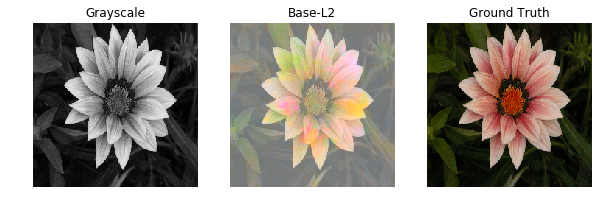

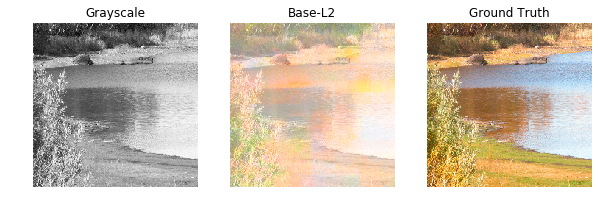

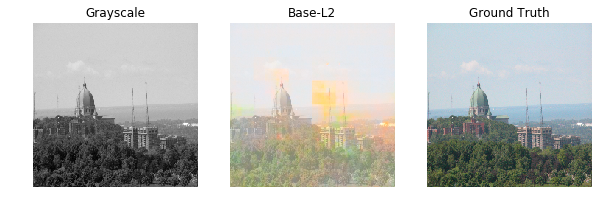

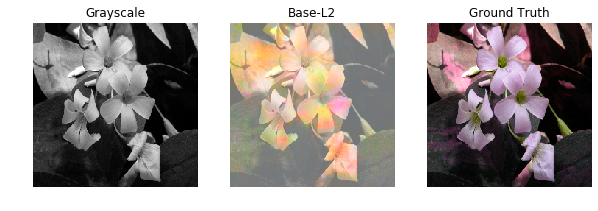

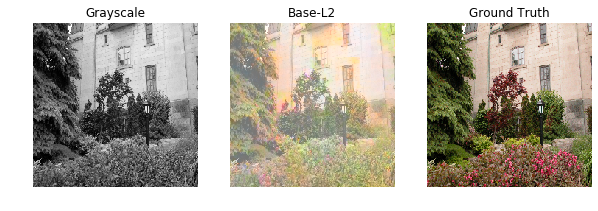

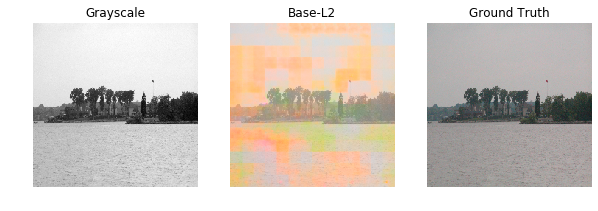

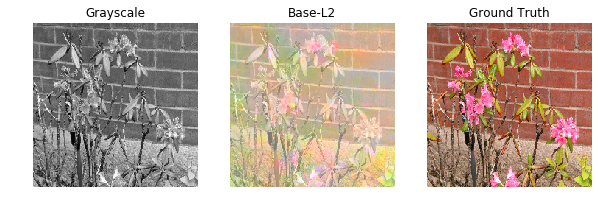

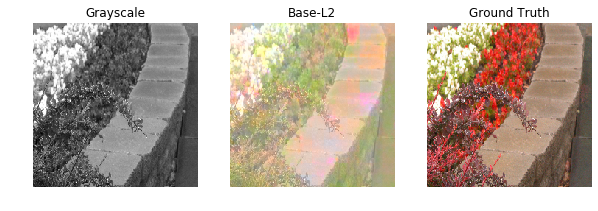

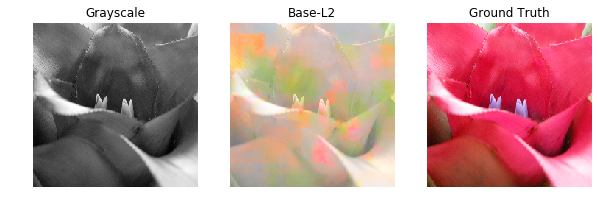

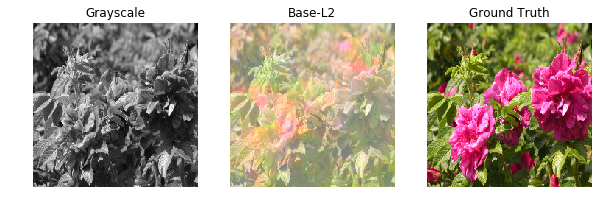

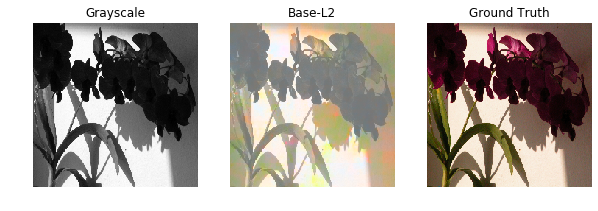

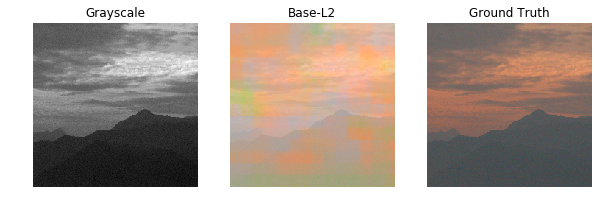

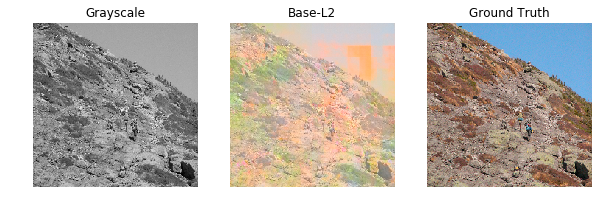

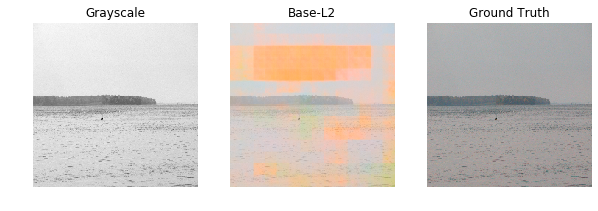

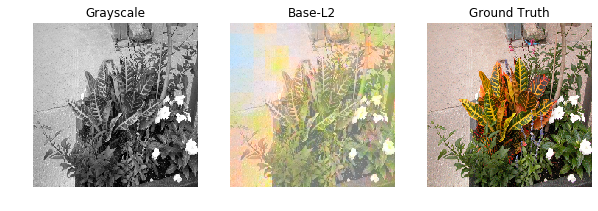

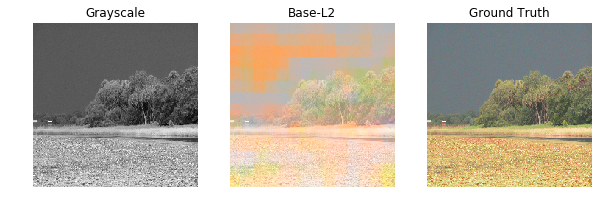

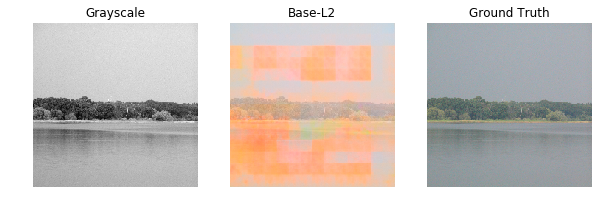

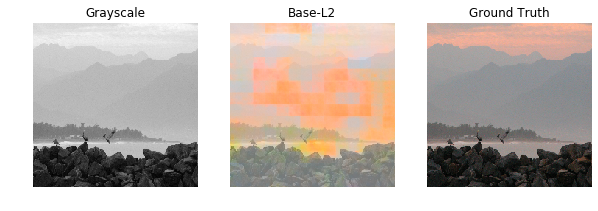

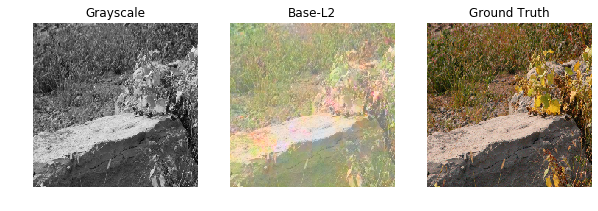

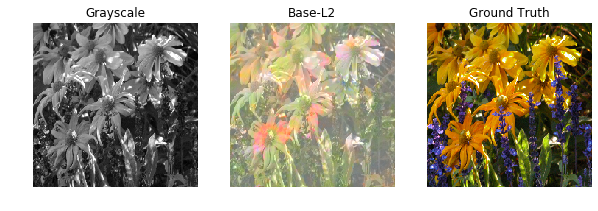

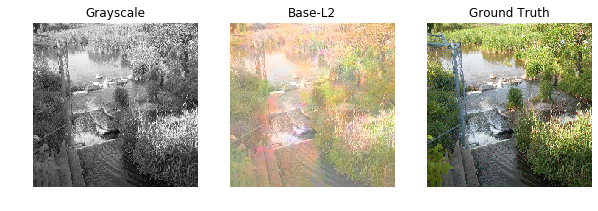

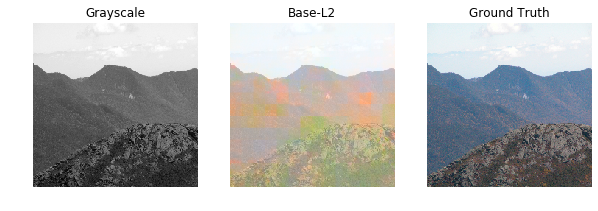

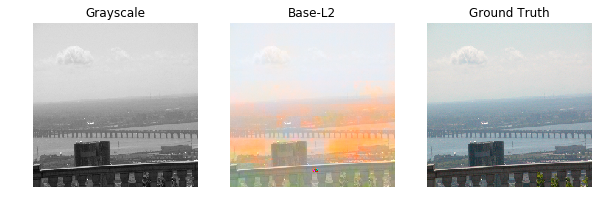

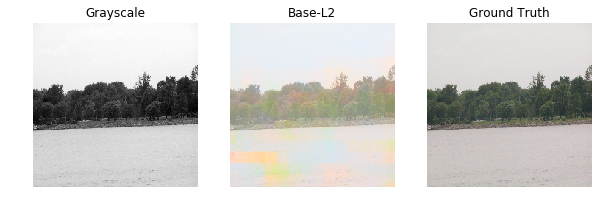

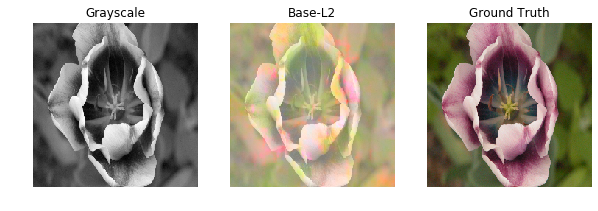

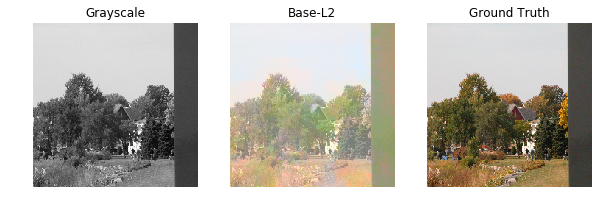

In [44]:
pred_base_l2 = predict(model=base_l2, X=test_X, Y=test_Y)
plotResult(true=test, pred_arr_list=[pred_base_l2], pred_label_list=['Base-L2'], num_imgs=len(test))